### Creation of bikeshares <> weather dataframe(data/result_parquet)

In [1]:
%run utilities.ipynb

In [2]:
spark = spark_session()

In [3]:
bikeshareDf = spark.read.csv('./data/sample.csv', header=True)

In [4]:
transformed_bikeshareDf = parse_date(bikeshareDf)

In [5]:
final_bikeshareDf = transformed_bikeshareDf\
    .withColumnRenamed('start station name', 'start_station_name')\
    .withColumnRenamed('end station name',  'end_station_name')\
    .withColumnRenamed('birth year', 'birth_year')



In [6]:
weatherDf = spark.read.csv('./data/weather_data_nyc_2016.csv', header=True)

weatherDf = weatherDf.withColumnRenamed('maximum temperature', 'maximum_temperature')\
                    .withColumnRenamed( 'minimum temperature', 'minimum_temperature')\
                    .withColumnRenamed('average temperature', 'average_temperature')\
                    .withColumnRenamed('snow fall', 'snow_fall')\
                    .withColumnRenamed('snow depth', 'snow_depth')


In [7]:
bikeshares_wheaterDf = final_bikeshareDf.join(weatherDf, final_bikeshareDf['date_for_join'] == weatherDf['date'], 'inner')

In [8]:
bikeshares_wheaterDf_final = bikeshares_wheaterDf.select( 'tripduration', 
                                                        'start_station_name', 
                                                        'end_station_name',
                                                        'usertype',
                                                        'birth_year',
                                                        'gender',
                                                        'date',
                                                        'maximum_temperature',
                                                        'minimum_temperature',
                                                        'average_temperature',
                                                        'precipitation',
                                                        'snow_fall',
                                                        'snow_depth')

In [9]:
handle_df_columns(bikeshares_wheaterDf, final_bikeshareDf)

OK!


In [10]:
bikeshares_wheaterDf_final.write.mode('overwrite').csv('./data/result_csv')

In [11]:
bikeshare_wheater_analyticsDf = spark.read.csv('./data/result_csv', schema=schema, header=True)

In [35]:
bikeshare_wheater_analyticsDf

DataFrame[tripduration: int, start_station_name: string, end_station_name: string, user_type: string, birthyear: int, gender: int, date: string, maximum_temperature: float, minimum_temperature: float, average_temperature: float, precipitation: float, snow_fall: float, snow_depth: float]

In [12]:
bikeshare_wheater_analyticsDf = preanalytics_filter(bikeshare_wheater_analyticsDf)

In [13]:
bikeshare_wheater_analyticsDf.write.mode('overwrite').parquet('./data/result_parquet')

### Start from here if `starter.sh` is executed or data/result_parquet is present

In [14]:
analyticsDf = spark.read.parquet('./data/result_parquet')

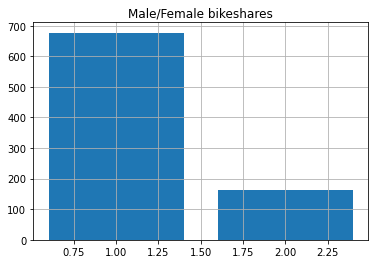

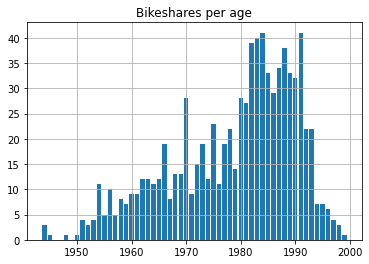

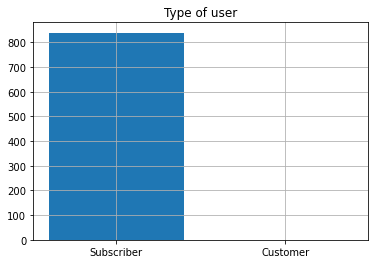

In [15]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as f
from collections import Counter

'''
 0 --> unknown
 1 --> male
 2 --> female
'''

def prepare_for_bar(column, title):
    xpoint = analyticsDf.select(f.collect_list(column)).first()[0]
    x = Counter(xpoint).keys()
    y = Counter(xpoint).values()

    
    plt.title(title)
    plt.grid()
    plt.bar(x, y)
    plt.show()
   
prepare_for_bar('gender', 'Male/Female bikeshares')

prepare_for_bar('birthyear', 'Bikeshares per age')

prepare_for_bar('user_type', 'Type of user')


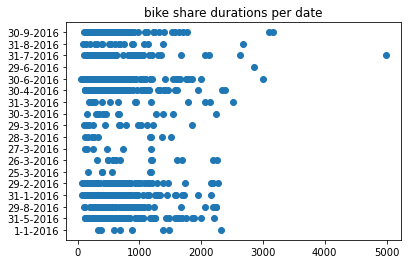

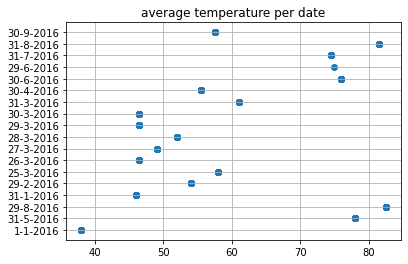

In [16]:

avg_temp = analyticsDf.select(f.collect_list('average_temperature')).first()[0]
tripdur = analyticsDf.select(f.collect_list('tripduration')).first()[0]
date = analyticsDf.select(f.collect_list('date')).first()[0]

plt.title('bike share durations per date')
plt.scatter(tripdur, date)

plt.show()
plt.title('average temperature per date')
plt.grid()
plt.scatter(avg_temp,date) 
plt.show()



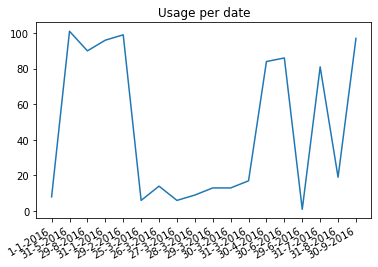

In [17]:
xpoint = analyticsDf.select(f.collect_list('date')).first()[0]
x = Counter(xpoint).keys()
y = Counter(xpoint).values()
fig, ax = plt.subplots()
ax.plot_date(x, y, marker='', linestyle='-')
fig.autofmt_xdate()
plt.title('Usage per date')
plt.show()


In [43]:
import seaborn as sns
import pandas as pd
import numpy as np

analyticsDf_pd = pd.read_csv('./data/result_csv/part-00000-02381e06-d6c2-47c6-a702-276dd4d74557-c000.csv',
                             names=['tripduration', 
                                     'start_station_name', 
                                     'end_station_name',
                                     'user_type',
                                     'birthyear', 
                                     'gender', 
                                     'date', 
                                     'maximum_temperature', 
                                     'minimum_temperature',
                                     'average_temperature', 
                                     'precipitation', 
                                     'snow_fall', 
                                     'snow_depth'])


/home/raddy/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


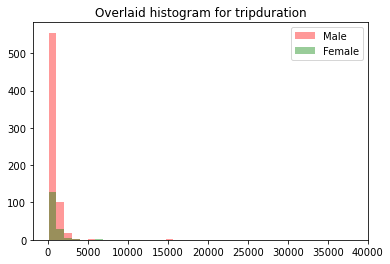

/home/raddy/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


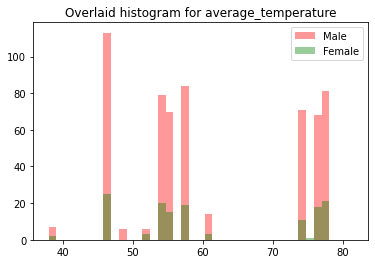

In [47]:
for i in ['tripduration', 'average_temperature']:    
    male = list(analyticsDf_pd[analyticsDf_pd['gender'] == 1][i].dropna())
    female = list(analyticsDf_pd[analyticsDf_pd['gender'] == 2][i].dropna())
    xmin = min(min(male), min(female))
    xmax = max(max(male), max(female))
    width = (xmax - xmin) / 40
    sns.distplot(male, color='r', kde=False, bins=np.arange(xmin, xmax, width))
    sns.distplot(female, color='g', kde=False, bins=np.arange(xmin, xmax, width))
    plt.legend(['Male', 'Female'])
    plt.title(f'Overlaid histogram for {i}')
    plt.show()
    